# Inflection point detection

The inflection points we are looking for are the points where the fluid around
the cylinder changes sign. These will move as vortices are formed and shed. We
are interested in detecting these points and tracking them over time.

Some of the cells in this notebook will have a check if the code is running in
a notebook or is imported. This is because the code is designed to be run in a
notebook, but it can also be imported and run in a script.

![image](media/close_up.png)

## Processing the data

The first step is to post-process the data to extract the inflection points.
This is done by probing the velocity field in a circle around the cylinder and
detecting the points where the velocity changes sign. Each point will be
converted to just an angle and a time, as the radius of the circle is fixed.


In [41]:
# Assign flags for debugging to alter the behaviour of the program

debug = False
root_folder = "../../"
# data_folder = "logs/cylinder_benchmark"
data_folder = "results/cylinder_benchmark"

Debug mode enabled


In [43]:
# Setup the paths for the project and load the external modules
import sys
import os

# Install any missing dependencies and setup the paths for the project
try:
    import numpy as np
    import matplotlib.pyplot as plt

except:
    print("Installing missing dependencies")
    %pip install numpy matplotlib numpy

    import numpy as np
    import matplotlib.pyplot as plt

# Load internal modules
try:
    from nekotop import *
except:
    sys.path.append(root_folder + "scripts/modules")
    from nekotop import *


## Inflection point detection

The inflection points we are looking for are the points where the fluid around
the cylinder changes sign. These will move as vortices are formed and shed. We
are interested in detecting these points and tracking them over time.

### Processing the data

The first step is to post-process the data to extract the inflection points.
This is done by probing the velocity field in a circle around the cylinder and
detecting the points where the velocity changes sign. Each point will be
converted to just an angle and a time, as the radius of the circle is fixed.


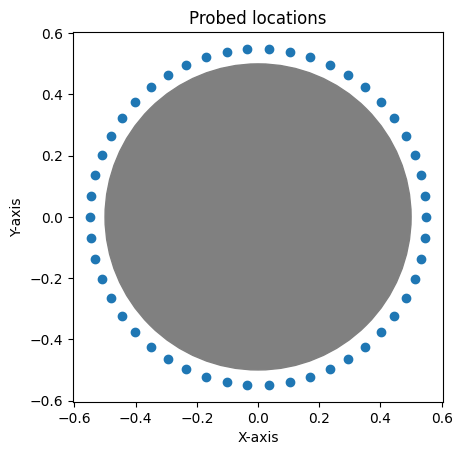

In [44]:
# Load data from the file and plot them to indicate where the probes are located
if __name__ == "__main__":

    if debug:
        print("Debug mode enabled")

    # Setup the paths for the project
    path = os.path.realpath(
        os.path.join(os.getcwd(), root_folder + data_folder)
    )

    # Check that the folder exists
    if not os.path.exists(path):
        print("The path to the results folder does not exist.")
        print("Please run the benchmark first.")
        print("\tcd NEKO_TOP_ROOT")
        print("\t./setup.sh")
        print("\t./run.sh cylinder_benchmark")
        exit(404)

    # Read in the file and setup the data
    file_name = "meshed/inflection.csv"

    # Check that the file exists
    if not os.path.exists(file_name):
        file_name = os.path.join(path, file_name)
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"The file: {file_name} does not exist.")

    # If the points variable is not initialized, read in the data
    if not "is_initialized" in locals():

        probes = Probes(file_name)

        points = probes.points
        fields = np.asarray(
            [probes.fields["u"][:], probes.fields["v"][:]]
        ).transpose()
        times = probes.times
        field_names = probes.field_names

        N_points = points.shape[0]
        N_fields = fields.shape[1]
        N_times = times.shape[0]
        is_initialized = True
        del probes

    # Plot the points in a 2D plot. (Z-axis should be constant)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1])

    # Add a circle for the cylinder boundary with radius 0.5
    circle = plt.Circle((0, 0), 0.5, color="gray", fill=True)
    ax.add_artist(circle)

    ax.set_aspect("equal")
    plt.title("Probed locations")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

In [45]:
def compute_angle(center, point, axis=np.array([1.0, 0.0, 0.0])):
    """
    Compute the angle between the center and the point
    """

    # Compute the angle
    angle = np.arctan2(point[1] - center[1], point[0] - center[0])

    return angle

In [46]:
def compute_radial_flow(angle, field) -> float:
    """
    Compute the radial flow of the field
    """

    # Compute the flow
    flow = -field[0] * np.sin(angle) + field[1] * np.cos(angle)

    return flow

In [47]:
def compute_inflection_angle(i0, direction, flow, angles) -> float:

    i_p = i0
    i_n = i_p + direction

    while flow[i_p] < 0 or flow[i_n] > 0:
        if flow[i_n] < 0:
            s = -direction
        else:
            s = +direction

        i_p = (i_p + s) % len(angles)
        i_n = (i_n + s) % len(angles)

    # Compute the angle of the inflection point
    angle_p = angles[i_p]
    angle_n = angles[i_n]
    flow_p = flow[i_p]
    flow_n = flow[i_n]

    return angle_n + (angle_p - angle_n) * flow_n / (flow_n - flow_p)

In [48]:
def track_inflection_point(center, points, fields, times):
    """
    Track the inflection point of the flow
    """

    N_points = points.shape[0]
    N_times = times.shape[0]

    angle_inflection = np.zeros([len(times), 3])
    angles = np.zeros(points.shape[0])
    for i_boundary in range(points.shape[0]):
        point = points[i_boundary, :]
        angles[i_boundary] = compute_angle(center, point)

    idx = np.argsort(angles)

    for ti in range(N_times):
        t = times[ti]

        flow = np.zeros(points.shape[0])
        for i_boundary in range(points.shape[0]):
            angle = angles[i_boundary]
            field = fields[i_boundary + ti * N_points, :]
            flow[i_boundary] = compute_radial_flow(angle, field)

        i0 = int(3 / 4 * len(idx))
        a0 = compute_inflection_angle(i0, 1, flow[idx], angles[idx])

        i0 = int(2 / 4 * len(idx))
        a1 = compute_inflection_angle(i0, -1, flow[idx], angles[idx])

        i0 = int(1 / 4 * len(idx))
        a2 = compute_inflection_angle(i0, 1, flow[idx], angles[idx])

        # The central inflection point cannot be outside the other two.
        if a0 < a1 or a1 < a2:
            a1 = 0.5 * (a0 + a2)

        angle_inflection[ti, :] = [a0, a1, a2]

    return angle_inflection

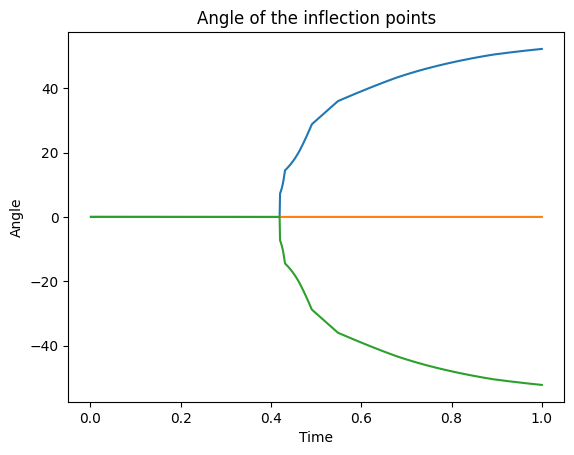

In [49]:
# Compute the inflection angles for all time steps
if __name__ == "__main__":

    if not "angles" in locals():
        center = np.array([0.0, 0.0, 0.0])
        angles = track_inflection_point(center, points, fields, times)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, angles * 360.0 / (2.0 * np.pi))

    plt.title("Angle of the inflection points")
    plt.xlabel("Time")
    plt.ylabel("Angle")
    plt.show()

### Detection of stable regions

The next step is to detect the regions where the inflection points are stable.
This is done by examining the time series of the inflection points and
detecting the regions where the oscillations are stable, i.e. the points are
oscillating around a fixed point with a fixed amplitude.

In general we will see 3 regions of interest:

1. The build-up of boundary layers. Here we will see the inflection points move
   from a central point close to the 0 angle to the final stable position.
2. Build-up of vortices. Here we will see the inflection points move from the
   stable position and begin to oscillate with increasing amplitude.
3. Shedding of vortices. Here we will see the inflection points oscillate with
   a large, but stable, amplitude.

#### The layer build-up

The build-up of the boundary layer is the first region of interest. Here we
will see the inflection points move from a central point close to the 0 angle
to the final stable position. We will examine their trajectory and determine
when they have reached a stable position.

#### The vortex build-up

The build-up of vortices is the second region of interest. Here we will see the
inflection points move from the stable position and begin to oscillate with
increasing amplitude. We will examine their amplitude and detect when the
amplitude have reached a stable value.

#### The vortex shedding

The shedding of vortices is the third region of interest. Here we will see the
inflection points oscillate with a large, but stable, amplitude. This is the
main region of interest. This is where we will be examining the frequencies of
the oscillations.

In [50]:
def detect_stable_regions(angles, threshold=0.1):
    """
    Detect stable regions in the angle data

    The function will return the indices delimiting the stable regions.

    Parameters
    ----------
    angles : np.ndarray
        The angles of the inflection points.
    threshold : float
        The threshold for the difference between the angles.

    Returns
    -------
    i_boundary : int
        The index at which the boundary regions have formed.
    i_building : int
        The index at which the vortex building is complete.
    """

    # Compute the difference between the inflection points
    diff = np.diff(angles, axis=0)

    i_boundary = 0
    max_diff = 0.0

    for i in range(1, angles.shape[0]):
        if diff[i - 1, :].max() < threshold and max_diff > 1e-2:
            i_boundary = i
            break

        max_diff = max(max_diff, diff[i - 1, :].max())

    i_building = i_boundary
    min_signal = np.array(angles[i_boundary, :], copy=True)
    max_signal = np.array(angles[i_boundary, :], copy=True)
    for i in range(i_boundary, angles.shape[0]):

        criterion_min = min(angles[i, :] - min_signal) < -threshold
        criterion_max = min(max_signal - angles[i, :]) < -threshold

        max_signal = np.maximum(max_signal, angles[i, :])
        min_signal = np.minimum(min_signal, angles[i, :])

        if criterion_min or criterion_max:
            i_building = i

    if i_boundary == angles.shape[0] - 1:
        raise ValueError("The layer formation is not detected.")

    if i_building == angles.shape[0] - 1:
        raise ValueError("The vortex building is not detected.")

    return i_boundary, i_building

In [51]:
# Detect the flow stages.
#
# We will be looking for 3 stages in the flow.
# - The boundary layer build up.
# - The vortex formation.
# - The vortex shedding.

if __name__ == "__main__":

    if not "i_boundary" in locals() or True:
        i_boundary, i_building = detect_stable_regions(angles, threshold=1e-6)

    print("The layer formation is detected at time: ", times[i_boundary])
    print("The vortex building is detected at time: ", times[i_building])

    # Extract the data for the stable region
    times_stable = times[i_building:]
    angles_stable = angles[i_building:, :]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, angles * 360.0 / (2.0 * np.pi))

    ax.axvline(x=times[i_boundary], color="r", linestyle="--")
    ax.axvline(x=times[i_building], color="r", linestyle="--")

    plt.title("Angle of the inflection points")
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [deg]")
    plt.show()

ValueError: The vortex building is not detected.

### Computation of statistics

The final step is to compute the statistics of the stable vortex shedding
region. This will include the frequency of the oscillations, the amplitude of
the oscillations and the phase shift between the different inflection points.

All of these measures are only interesting once the vortex shedding have reached
a stable oscillatory state. This is typically after the boundary layers have
formed and the vortices have started to shed.

1. The frequency is computed using a Fourier transform of the time series of the
   inflection angles.
2. The amplitude is computed as the maximum deviation from the mean of the
   inflection angles.


In [ ]:
def compute_vortex_frequency(times, angles):
    """
    Compute the vortex shedding frequency

    The function will compute the frequency spectrum of the inflection points
    and return the dominant frequencies.

    Parameters
    ----------
    times : np.array
        The time steps.
    angles : np.ndarray
        The angle time series of the inflection points.

    Returns
    -------
    frequencies : np.array
        The frequencies list.
    spectrum : np.array
        The frequency spectrum of the inflection points.
    """

    # Compute the frequency spectrum of the signals
    frequencies = np.fft.fftfreq(len(times), d=times[1] - times[0])
    frequencies = np.fft.fftshift(frequencies)

    spectrum = np.zeros([len(frequencies), 3], dtype=complex)
    for i in range(3):
        spectrum[:, i] = np.fft.fft(angles[:, i] - angles[:, i].mean())
        spectrum[:, i] = np.fft.fftshift(spectrum[:, i])

        # Normalize the spectrum
        spectrum[:, i] /= sum(np.abs(spectrum[:, i]))

    return frequencies, spectrum

In [ ]:
def compute_max_frequency(spectrum, frequencies):
    """
    Compute the dominant frequencies

    The function will compute the dominant frequencies of the inflection points.

    Parameters
    ----------
    spectrum : np.array
        The frequency spectrum of the inflection points.
    frequencies : np.array
        The frequencies list.

    Returns
    -------
    max_freq : np.array
        The dominant frequencies of the inflection points.
    """
    # Print the dominant frequencies
    max_freq = np.zeros(3)
    for i in range(3):
        idx = np.argmax(np.abs(spectrum[:, i]))
        max_freq[i] = np.abs(frequencies[idx])

    return max_freq

In [ ]:
def compute_amplitudes(angles):
    """
    Compute the amplitudes of the inflection points

    The function will compute the amplitudes of the inflection points.

    Parameters
    ----------
    angles : np.ndarray
        The angle time series of the inflection points.

    Returns
    -------
    amplitude : np.array
        The amplitudes of the inflection points.
    """

    mu = np.mean(angles, axis=0)

    amplitude = np.array(
        [
            (angles[:, i] - mu[i]).max() - (angles[:, i] - mu[i]).min()
            for i in range(angles.shape[1])
        ]
    )

    return amplitude

In [ ]:
def compute_bias(angles):
    """
    Compute the bias of the inflection points

    The function will compute the bias of the inflection points. Aka the mean
    value.

    Parameters
    ----------
    angles : np.ndarray
        The angle time series of the inflection points.

    Returns
    -------
    bias : np.array
        The bias of the inflection points.
    """

    bias = np.mean(angles, axis=0)

    return bias

In [ ]:
# Compute the frequency spectrum of the inflection points
#
# Detect the frequencies present in the inflection point signals display them as
# frequency spectrum. This should allow us to classify the dominant frequencies.

if __name__ == "__main__":

    test_times = times[i_building:]
    test_angles = angles[i_building:, :]

    frequencies, spectrum = compute_vortex_frequency(test_times, test_angles)
    max_freq = compute_max_frequency(spectrum, frequencies)
    amplitude = compute_amplitudes(test_angles)
    bias = compute_bias(test_angles)

    print("The dominant frequency for the inflection points are:")
    for i in range(len(max_freq)):
        print(f"\t{max_freq[i]:.2f} Hz")

    print("The dominant amplitude for the inflection points are:")
    for i in range(len(amplitude)):
        print(f"\t{amplitude[i]:.2f} rad")

    print("The bias for the inflection points are:")
    for i in range(len(bias)):
        print(f"\t{bias[i]:.2f} rad")

    fig = plt.figure()
    fig.clf()

    ax0 = fig.add_subplot(311)
    plt.stem(frequencies,
             np.abs(spectrum[:, 0]),
             "b",
             markerfmt=" ",
             basefmt="-b")
    plt.xlim([0, 1])

    ax1 = fig.add_subplot(312)
    plt.stem(frequencies,
             np.abs(spectrum[:, 1]),
             "b",
             markerfmt=" ",
             basefmt="-b")
    plt.xlim([0, 1])

    ax2 = fig.add_subplot(313)
    plt.stem(frequencies,
             np.abs(spectrum[:, 2]),
             "b",
             markerfmt=" ",
             basefmt="-b")
    plt.xlim([0, 1])

    plt.suptitle("Frequency spectrum of the inflection points")
    plt.xlabel("Frequency [Hz]")
    plt.show()

## Conclusion and final function

The full benchmarking functipon will be defined bellow. The resulting `dict`
will contain all information relevant to compare multiple flows bast a cylinder.
This concludes this development notebook and one should look into the
`cylinder_benchmark` notebook for the final implementation.


In [ ]:
def inflection_benchmark(file_name: str) -> dict:
    """
    Run the inflection benchmark for a given file.

    The function will run the inflection benchmark for the given file and
    return the results.

    Parameters
    ----------
    file_name : str
        The name of the file to run the benchmark on.

    Returns
    -------
    benchmark_results : dict
        The results of the benchmark.
        times: np.array
            The time steps.
        angles: np.ndarray
            The angle time series of the inflection points.
        max_freq: np.array
            The dominant frequencies of the inflection points.
        amplitude: np.array
            The amplitudes of the inflection points.
        bias: np.array
            The bias of the inflection points.
        i_boundary: int
            The index at which the boundary regions have formed.
        i_building: int
            The index at which the vortex building is complete.
    """

    # Read in the file and setup the data
    probes = Probes(file_name)

    points = probes.points
    fields = np.asarray(
        [probes.fields["u"][:], probes.fields["v"][:]]
    ).transpose()
    times = probes.times

    center = np.array([0.0, 0.0, 0.0])
    angles = track_inflection_point(center, points, fields, times)

    i_boundary, i_building = detect_stable_regions(angles, threshold=1e-6)

    test_times = times[i_building:]
    test_angles = angles[i_building:, :]

    frequencies, spectrum = compute_vortex_frequency(test_times, test_angles)
    max_freq = compute_max_frequency(spectrum, frequencies)
    amplitude = compute_amplitudes(test_angles)
    bias = compute_bias(test_angles)

    benchmark_results = dict(
        times=times,
        angles=angles,
        i_boundary=i_boundary,
        i_building=i_building,
        max_freq=max_freq,
        amplitude=amplitude,
        bias=bias,
    )

    return benchmark_results

In [ ]:
if __name__ == "__main__":
    # Run the inflection benchmark for the meshed cylinder
    if "benchmark_results" not in locals():
        benchmark_results = inflection_benchmark(file_name)

    print("The dominant frequency for the inflection points are:")
    for i in range(len(benchmark_results["max_freq"])):
        print(f"\t{benchmark_results['max_freq'][i]:.2f} Hz")

    print("The dominant amplitude for the inflection points are:")
    for i in range(len(benchmark_results["amplitude"])):
        print(f"\t{benchmark_results['amplitude'][i]:.2f} rad")

    print("The bias for the inflection points are:")
    for i in range(len(benchmark_results["bias"])):
        print(f"\t{benchmark_results['bias'][i]:.2f} rad")